In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Change the path accordingly
root_path = 'gdrive/MyDrive/Siamese_Omniglot/' 
data_path = root_path + 'dataset/'

In [1]:
# !pip install vit_pytorch
!pip install timm

  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/01/a5/eeb717242343d9ca34e7de554a6c08d96a0cfc7005ece4f847b1753581a6/timm-0.9.12-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for safetensors from https://files.pythonhosted.org/packages/0c/84/1e59b0594ca421ff308169b0802d72adcce359619925141b69d2ebc89269/safetensors-0.4.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.3/426.3 kB 23.0 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import hashlib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler
import torch.optim.lr_scheduler as lr_scheduler
import random
import time
# from vit_pytorch.vit_for_small_dataset import ViT
import pickle
import timm
from timm import create_model

Creating pairs for Siamese Network

In [ ]:
class SiameseTrainData_ImageFolder(Dataset):
    '''
    Train: For each sample creates randomly a positive or a negative pairs
    '''

    def __init__(self, dataset):
        self.dataset = dataset
        self.imgs = list(enumerate(self.dataset.imgs))

    def __getitem__(self, index):
        target = np.random.randint(0, 2)
        img1, label1 = self.dataset[index]
        # same class
        if target == 1: 
            while True:
                siamese_index, (_, label2) = random.choice(self.imgs)
                if label1 == label2:
                    break
        # different class
        else:
            label2 = label1
            while label2 == label1:
                siamese_index, (_, label2) = random.choice(self.imgs)

        img2, label2 = self.dataset[siamese_index]
        target = torch.from_numpy(np.array([target]))
        return (img1, img2, target)

    def __len__(self):
        return len(self.dataset)

# adapted from https://github.com/fangpin/siamese-network
class SiameseTestData_ImageFolder(Dataset):

    def __init__(self, dataset, times=200, way=20, seed=0):
        self.dataset = dataset
        self.imgs = list(enumerate(self.dataset.imgs))
        self.times = times
        self.way = way
        self.seed = seed

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        self.rng = random.Random(self.seed + index)

        idx = index % self.way
        label = None

        # image frm same class
        if idx == 0:
            self.img1, self.label1 = self.dataset[index]
            while True:
                siamese_index, (_, label2) = self.rng.choice(self.imgs)
                if self.label1 == label2:
                    break
        # image from different class
        else:
            label2 = self.label1
            while label2 == self.label1:
                siamese_index, (_, label2) = self.rng.choice(self.imgs)
        img2, label2 = self.dataset[siamese_index]
        # print(self.label1, label2)
        return (self.img1), img2

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
input_size = 224#105
learning_rate = 1e-3
epochs = 100
sched_reset = 0
batch_size = 32
num_workers = 2
way = 20
model_name = "vit_base_patch16_224"     #pretrained vit model

In [ ]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    cuda = True
    pin_memory = True
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((input_size,input_size),interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomRotation(10),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))]),
        'val': transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((input_size,input_size),interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))])
    }

In [ ]:
trainset = datasets.ImageFolder(data_path +'changed/train', transform=data_transforms['train'])
valset = datasets.ImageFolder(data_path +'changed/valid', transform=data_transforms['val'])
testset =  datasets.ImageFolder(data_path +'changed/test', transform=data_transforms['val'])

In [ ]:
train_siamese = SiameseTrainData_ImageFolder(trainset)
val_siamese = SiameseTestData_ImageFolder(valset, times=int(len(valset)/way))
test_siamese = SiameseTestData_ImageFolder(testset, times=int(len(testset)/way))

In [ ]:
trainloader = torch.utils.data.DataLoader(train_siamese, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
valloader = torch.utils.data.DataLoader(val_siamese, batch_size=way, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
testloader = torch.utils.data.DataLoader(test_siamese, batch_size=way, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
class Siamese_ViT(nn.Module):

    def __init__(self):
        super(Siamese_ViT, self).__init__()
        self.features = create_model(model_name, pretrained=True, in_chans = 1)
        
        self.features.head = nn.Linear(self.features.head.in_features, 4096)

        self.fc = nn.Sequential(
            # nn.Dropout(),
            nn.GELU(),
            nn.Linear(4096,2048),
            
            nn.GELU(),
            # nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024,512),
            nn.GELU(),
            nn.Linear(512,128),
            # nn.Sigmoid(),
            nn.Tanh(),
            # nn.Linear(128, 16)
        )
        self.output = nn.Linear(128, 1)


    
    def forward_one(self, x):
        x = self.features(x)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dist = torch.abs(out1 - out2)
        out = self.output(dist)
        # print("Model is defined")
        return out

In [ ]:
model = Siamese_ViT()

optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum = 0.9)

if cuda:
    model.to(device)

In [ ]:
scheduler = lr_scheduler.StepLR(optimizer, gamma=0.99, step_size=1)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, device, debug=False, print_freq=200):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()
    # print("entered train function")
    end = time.time()
    for batch_idx, (imgs1, imgs2, targets) in enumerate(train_loader):
        # print("entered batch loop")
        data_time.update(time.time() - end)

        imgs1 = imgs1.to(device).float()
        imgs2 = imgs2.to(device).float()
        targets = targets.to(device).float()
        
        optimizer.zero_grad()
        output = model(imgs1, imgs2)
        loss = criterion(output, targets)
        losses.update(loss.item(), imgs1.size(0))
        
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                      epoch, batch_idx, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses))
        if debug:
            break

    return losses.avg

In [ ]:
def validate(val_loader, model, epoch, device, print_freq=100):
    batch_time = AverageMeter()
    accuracy = AverageMeter()
    # switch to evaluate mode
    model.eval()
    correct, wrong = 0, 0
    with torch.no_grad():
        end = time.time()
        for batch_idx, (imgs1, imgs2) in enumerate(val_loader):
            imgs1 = imgs1.to(device).float()
            imgs2 = imgs2.to(device).float()
            
            output = model(imgs1, imgs2)
            pred = np.argmax(output.cpu().numpy())
            if pred == 0 and output.cpu().numpy().std()>0.01:
                correct += 1
            else: 
                wrong += 1
           
            acc = float(correct)/(correct+wrong)
            accuracy.update(acc, correct+wrong)
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

    print('Test: [{0}][{1}/{2}]\t'
          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          'Correct {correct} \t Wrong {wrong}\t'
          'Accuracy {acc.val:.3f} ({acc.avg:.3f})\t'.format(
              epoch, batch_idx, len(val_loader), batch_time=batch_time,
              correct=correct, wrong=wrong,
              acc=accuracy))
        
    return accuracy.avg

In [ ]:
# This Cell ran for sometime before Colab timeout
# train_losses = []
# val_accs = []
# epoch_time = AverageMeter()
# ep_end = time.time()
# best_acc = -1
# for e in range(epochs):
    
#     print('*'*70)
#     train_loss = train(trainloader, model, criterion, optimizer, e, device, False, 3)
#     train_losses.append(train_loss)
#     scheduler.step()
#     print('-'*70)
#     val_acc = validate(valloader, model, e, device) 
#     print('Avg validation acc: {:.3f}'.format(val_acc))
#     val_accs.append(val_acc)
#     print('-'*70)
        
#     if best_acc < val_acc:
#         best_acc = val_acc
#         # model_path = os.path.join('weights', 'kochnetv2_{}.pth'.format(e))
#         torch.save(model.state_dict(), root_path+ 'Model/stored weights/vit/vit-model-epoch-%s.pth' % e)
#         # torch.save(model.state_dict(), model_path)
#         print('New model saved to {} with accuracy {:.3f}'.format(root_path+ 'Model/stored weights/vit/', best_acc))
        
#     epoch_time.update(time.time() - ep_end)
#     ep_end = time.time()
#     print('Epoch {}/{}\t'
#           'Time {epoch_time.val:.3f} ({epoch_time.avg:.3f})'.format(e, epochs - 1, epoch_time=epoch_time))
    

**********************************************************************
Epoch: [0][0/502]	Time 1.104 (1.104)	Data 0.315 (0.315)	Loss 0.6917 (0.6917)
Epoch: [0][3/502]	Time 1.118 (1.138)	Data 0.000 (0.079)	Loss 0.6971 (0.6944)
Epoch: [0][6/502]	Time 1.117 (1.129)	Data 0.000 (0.045)	Loss 0.6933 (0.6936)
Epoch: [0][9/502]	Time 1.117 (1.126)	Data 0.000 (0.032)	Loss 0.6932 (0.6938)
Epoch: [0][12/502]	Time 1.120 (1.125)	Data 0.000 (0.025)	Loss 0.6931 (0.6930)
Epoch: [0][15/502]	Time 1.120 (1.124)	Data 0.000 (0.020)	Loss 0.6903 (0.6933)
Epoch: [0][18/502]	Time 1.115 (1.123)	Data 0.000 (0.017)	Loss 0.6969 (0.6936)
Epoch: [0][21/502]	Time 1.120 (1.123)	Data 0.000 (0.015)	Loss 0.6953 (0.6937)
Epoch: [0][24/502]	Time 1.121 (1.122)	Data 0.000 (0.013)	Loss 0.6938 (0.6938)
Epoch: [0][27/502]	Time 1.117 (1.122)	Data 0.000 (0.012)	Loss 0.6894 (0.6936)
Epoch: [0][30/502]	Time 1.117 (1.121)	Data 0.000 (0.011)	Loss 0.6928 (0.6935)
Epoch: [0][33/502]	Time 1.116 (1.121)	Data 0.000 (0.010)	Loss 0.6955 (0.693

In [ ]:
#Loading the model to continue training after colab timeout
past_epoch = 14
model.load_state_dict(torch.load(root_path+ 'Model/stored weights/vit/vit-model-epoch-13.pth'))

<All keys matched successfully>

In [ ]:
train_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
best_acc = -1
for e in range(past_epoch,past_epoch+epochs):
    
    print('*'*70)
    train_loss = train(trainloader, model, criterion, optimizer, e, device, False, 3)
    train_losses.append(train_loss)
    scheduler.step()
    print('-'*70)
    val_acc = validate(valloader, model, e, device) 
    print('Avg validation acc: {:.3f}'.format(val_acc))
    val_accs.append(val_acc)
    print('-'*70)
        
    if best_acc < val_acc:
        best_acc = val_acc
        # model_path = os.path.join('weights', 'kochnetv2_{}.pth'.format(e))
        torch.save(model.state_dict(), root_path+ 'Model/stored weights/vit/vit-model-epoch-%s.pth' % e)
        # 
        print('New model saved to {} with accuracy {:.3f}'.format(root_path+ 'Model/stored weights/vit/', best_acc))
        
    epoch_time.update(time.time() - ep_end)
    ep_end = time.time()
    print('Epoch {}/{}\t'
          'Time {epoch_time.val:.3f} ({epoch_time.avg:.3f})'.format(e, epochs - 1, epoch_time=epoch_time))
    

Streaming output truncated to the last 5000 lines.
Epoch: [85][138/502]	Time 1.118 (1.117)	Data 0.000 (0.002)	Loss 0.0100 (0.0227)
Epoch: [85][141/502]	Time 1.117 (1.117)	Data 0.000 (0.002)	Loss 0.0778 (0.0230)
Epoch: [85][144/502]	Time 1.118 (1.117)	Data 0.000 (0.002)	Loss 0.0090 (0.0227)
Epoch: [85][147/502]	Time 1.115 (1.117)	Data 0.000 (0.002)	Loss 0.0087 (0.0228)
Epoch: [85][150/502]	Time 1.116 (1.117)	Data 0.000 (0.002)	Loss 0.0186 (0.0226)
Epoch: [85][153/502]	Time 1.120 (1.117)	Data 0.000 (0.002)	Loss 0.0144 (0.0225)
Epoch: [85][156/502]	Time 1.118 (1.117)	Data 0.000 (0.002)	Loss 0.0165 (0.0224)
Epoch: [85][159/502]	Time 1.115 (1.117)	Data 0.000 (0.002)	Loss 0.0104 (0.0226)
Epoch: [85][162/502]	Time 1.117 (1.117)	Data 0.000 (0.002)	Loss 0.0131 (0.0226)
Epoch: [85][165/502]	Time 1.113 (1.117)	Data 0.000 (0.002)	Loss 0.0110 (0.0225)
Epoch: [85][168/502]	Time 1.120 (1.117)	Data 0.000 (0.002)	Loss 0.0073 (0.0223)
Epoch: [85][171/502]	Time 1.115 (1.117)	Data 0.000 (0.002)	Loss 0.011

In [ ]:
print(train_losses)

[0.13113971877736438, 0.126347009987938, 0.1215500197033508, 0.11189818283262318, 0.10933467775100789, 0.10250486549486407, 0.09392454604876888, 0.0948691646474533, 0.08961353815655929, 0.08371381805015085, 0.08094546950769009, 0.08163821536347103, 0.07126889977775802, 0.0721799265820612, 0.07110513982967304, 0.06512759255331153, 0.06072023618748298, 0.060805090328453486, 0.058526384936248975, 0.05528254297795064, 0.055242962730702845, 0.05320038575943499, 0.0553216029946712, 0.051964492128598286, 0.0460635556694431, 0.04910418737127653, 0.042072568321658545, 0.04300566530910554, 0.04420991454036862, 0.043508650657545736, 0.04375522076378427, 0.03999920686055091, 0.04078552266687229, 0.038723553479608534, 0.035707232198338136, 0.035104815594174645, 0.033652560052880615, 0.03484834541484324, 0.0360335243283626, 0.04025918110128803, 0.03526298919481551, 0.033294787358116834, 0.03313941856658325, 0.03033199350339167, 0.028843668794461236, 0.028688109612990065, 0.028270385597147056, 0.0321

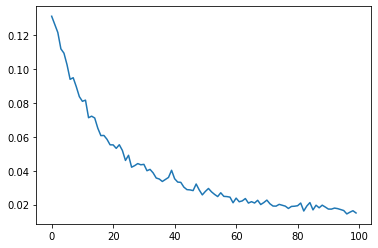

In [ ]:
plt.plot(train_losses)

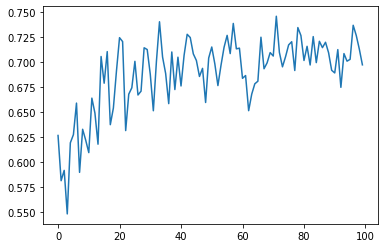

In [ ]:
plt.plot(val_accs)

In [ ]:
#Saving losses in a pickle file
with open(root_path + "Vit_train_loss.pickle", "wb") as f:
    pickle.dump(train_losses,f)
with open(root_path + "Vit_val_accs.pickle", "wb") as f:
    pickle.dump(val_accs,f)

In [ ]:
# Loading the best model
final_model = Siamese_ViT()
final_model.load_state_dict(torch.load(root_path+ 'Model/stored weights/vit/vit-model-epoch-85.pth'))
if cuda:
    final_model.to(device)

In [ ]:
def validate(val_loader, model, epoch, device, print_freq=100):
    batch_time = AverageMeter()
    accuracy = AverageMeter()
    # switch to evaluate mode
    model.eval()
    correct, wrong = 0, 0
    with torch.no_grad():
        end = time.time()
        for batch_idx, (imgs1, imgs2) in enumerate(val_loader):
            imgs1 = imgs1.to(device).float()
            imgs2 = imgs2.to(device).float()
            
            output = model(imgs1, imgs2)

            pred = np.argmax(output.cpu().numpy())
            if pred == 0:
                correct += 1
            else: 
                wrong += 1
           
            acc = float(correct)/(correct+wrong)
            accuracy.update(acc, correct+wrong)
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            print('Test: [{0}][{1}/{2}]\t'
          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          'Correct {correct} \t Wrong {wrong}\t'
          'Accuracy {acc.val:.3f} ({acc.avg:.3f})\t'.format(
              epoch, batch_idx, len(val_loader), batch_time=batch_time,
              correct=correct, wrong=wrong,
              acc=accuracy))
        
    return accuracy.avg
test_acc = validate(testloader, final_model, 1, device)

Test: [1][0/659]	Time 0.396 (0.396)	Correct 1 	 Wrong 0	Accuracy 1.000 (1.000)	
Test: [1][1/659]	Time 0.248 (0.322)	Correct 1 	 Wrong 1	Accuracy 0.500 (0.667)	
Test: [1][2/659]	Time 0.248 (0.298)	Correct 2 	 Wrong 1	Accuracy 0.667 (0.667)	
Test: [1][3/659]	Time 0.247 (0.285)	Correct 2 	 Wrong 2	Accuracy 0.500 (0.600)	
Test: [1][4/659]	Time 0.248 (0.278)	Correct 3 	 Wrong 2	Accuracy 0.600 (0.600)	
Test: [1][5/659]	Time 0.247 (0.273)	Correct 3 	 Wrong 3	Accuracy 0.500 (0.571)	
Test: [1][6/659]	Time 0.247 (0.269)	Correct 4 	 Wrong 3	Accuracy 0.571 (0.571)	
Test: [1][7/659]	Time 0.247 (0.266)	Correct 4 	 Wrong 4	Accuracy 0.500 (0.556)	
Test: [1][8/659]	Time 4.873 (0.778)	Correct 5 	 Wrong 4	Accuracy 0.556 (0.556)	
Test: [1][9/659]	Time 0.773 (0.778)	Correct 6 	 Wrong 4	Accuracy 0.600 (0.564)	
Test: [1][10/659]	Time 4.860 (1.149)	Correct 7 	 Wrong 4	Accuracy 0.636 (0.576)	
Test: [1][11/659]	Time 1.098 (1.144)	Correct 8 	 Wrong 4	Accuracy 0.667 (0.590)	
Test: [1][12/659]	Time 5.314 (1.465)	C

In [ ]:
print(test_acc)

0.7109026532395273
